In [1]:
import numpy as np
import math
import time
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from astropy.io import fits
from odlib import *

Semi-major axis: 
	actual: 1.535501123505049 
	calculated: 1.5347326380022122 
	error: 0.050047863272331704
Eccentricity: 
	actual: 0.1980131722243141 
	calculated: 0.1970528139135287 
	error: 0.48499718478198134
Inclination: 
	actual: 11.27908127242095 
	calculated: 11.297805611270112 
	error: 0.16600943283338615
Longitude of Ascending Node: 
	actual: 196.197631075624 
	calculated: 196.30891625203841 
	error: 0.05672095825230317
Argument of perihelion: 
	actual: 142.5325538303718 
	calculated: 142.4976525114411 
	error: 0.024486559731640926
Time of Perihelion Passage T: 
	actual: 2459161.8777567465 
	calculated: 2459162.6487638657 
	error: 3.135243459107353e-05


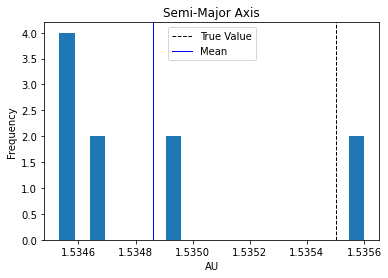

Semi-Major Axis: 
	mean: 1.5348613830028468
	error: 0.0416633040776916
	standard deviation of mean: 0.0003919887186726676



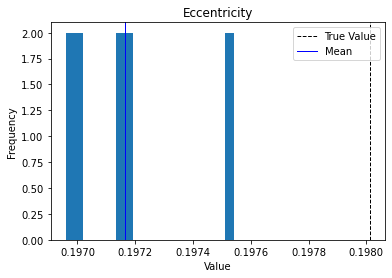

Eccentricity: 
	mean: 0.1971630879390074
	error: 0.429306937390876
	standard deviation of mean: 0.0002056151785986691



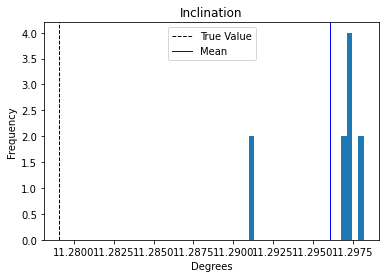

Inclination: 
	mean: 11.296085201727298
	error: 0.15075633285776
	standard deviation of mean: 0.0025989288776188876



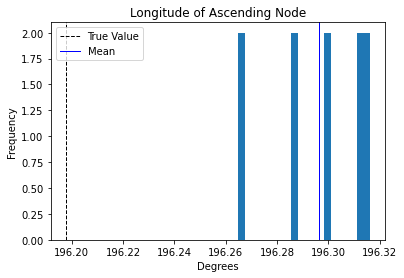

Longitude of Ascending Node: 
	mean: 196.29648171828936
	error: 0.05038319888136293
	standard deviation of mean: 0.018643619367408795



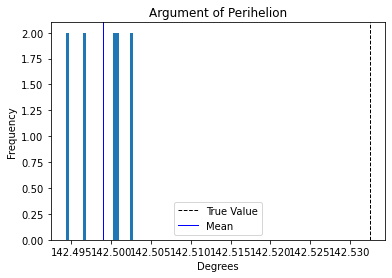

Argument of Perihelion: 
	mean: 142.49890771629453
	error: 0.023605915401834123
	standard deviation of mean: 0.003059890582164883



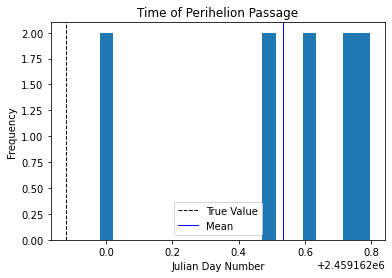

Time of Perihelion Passage: 
	mean: 2459162.534452021
	error: 2.6704027928213836e-05
	standard deviation of mean: 0.29472993233473727



In [3]:
def RunCompleteOD(iterations:int, inputFile:str, fitsFiles:list, sunFile:str, dates:list, results:list):
    # generate orbital elements
    data=Data()
    od=OD(inputFile)
    od.MoG(selDate=dates)
    
    # determine error
    a,e,i,o,w,m,T = results
    od.getError([e,0,i,o,w,T,0,0,0,a])
    od.exportResults(2459784.7916667, "July 24, 2022 7:00 UT", "SoongODResults.txt") 
    
    # Monte Carlo
    results = [a,e,i,o,w,T] 
    od.monteCarlo(iterations, fitsFiles, "SoongMonteCarloOutput.txt", results, selDate=dates)
    
    # generate the ephemeris
    od.genEphemeris(sunFile, "SoongGeneratedEphemeris.txt")

iterations=5 # Monte Carlo Iterations
inputFile="/home/soonali/Desktop/SSP2022/SoongInput.txt" # Input File path
sunFile="/home/soonali/Desktop/SSP2022/1999GJ2SunPos.txt" # Path for file containing times and sun positions for ephemeris generation
fitsFiles=["/home/soonali/Desktop/SSP2022/0628.fits", 
           "/home/soonali/Desktop/SSP2022/0712.fits", 
           "/home/soonali/Desktop/SSP2022/0714.fits"] # Fits Files path
dates=['2022-06-28 04:33:44.089','2022-07-12 04:16:40.826','2022-07-14 04:41:39.025'] # Dates selected
results=[1.535501123505049E+00, 1.980131722243141E-01, 1.127908127242095E+01, 
         1.961976310756240E+02, 1.425325538303718E+02, 3.163937598615976E+02, 
         2459856.859881772194] # [a,e,i,o,w,m,T], results from JPL horizons for 2022-07-12 04:16:40.826

RunCompleteOD(iterations, inputFile, fitsFiles, sunFile, dates, results)

In [4]:
def GenerateEphemeris(inputFile:str, ODdates:list, sunFile:str):
    """ 
        Outputs ephemeris to file.
        Args: 
            inputFile (str): path for file containing observations to determine orbital elements
            ODdates (list): list of dates for orbital elements determination
            sunFile (str): path for file containing times and sun positions for ephemeris generation
        Returns:
            None
    """
    
    # calculating orbital elements
    data=Data()
    od=OD(inputFile)
    od.MoG(selDate=dates)
    
    # generate ephemeris
    od.genEphemeris(sunFile, "GeneratedEphemeris.txt")
    
    print("Finished generating ephemeris")

inputFile = "/home/soonali/Desktop/SSP2022/SoongInput.txt"
sunFile = "/home/soonali/Desktop/SSP2022/1999GJ2SunPos.txt"
ODdates = ['2022-06-28 04:33:44.089','2022-07-12 04:16:40.826','2022-07-14 04:41:39.025']
GenerateEphemeris(inputFile, ODdates, sunFile)

Finished generating ephemeris
